In [1]:
import sys
import copy
import itertools
import logging
import os

import networkx as nx
import numpy as np
import torch
from rdkit import Chem
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../"))

from Source.explanations.rdkit_heatmaps import mapvalues2mol
from Source.explanations.rdkit_heatmaps.utils import transform2png
from Source.explanations.shapley import l_shapley
from Source.models.GCNN_FCNN.featurizers import featurize_sdf_with_metal_and_conditions, SkipatomFeaturizer
from Source.models.GCNN_FCNN.model import GCNN_FCNN
from Source.models.GCNN_FCNN.old_featurizer import ConvMolFeaturizer
from Source.trainer import ModelShell
from config import ROOT_DIR

/home/pikulin/.conda/envs/logK/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pikulin/.conda/envs/logK/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def create_path(path):
    if os.path.exists(path) or path == "":
        return
    head, tail = os.path.split(path)
    create_path(head)
    os.mkdir(path)

In [3]:
def classification_dataset(dataset, num_classes, thresholds=None):
    dataset = copy.deepcopy(dataset)
    all_values = np.array([graph.y["logK"].item() for graph in dataset])
    thresholds = thresholds or [np.percentile(all_values, (i + 1) * 100 / num_classes) for i in range(num_classes)]
    for graph in dataset:
        class_id = torch.tensor([num_classes - 1], dtype=torch.int64)
        for i, threshold in enumerate(thresholds[::-1]):
            if graph.y["logK"].item() < threshold:
                class_id = torch.tensor([num_classes - i - 1], dtype=torch.int64)
        graph.y = {"logK_class": class_id}
    return dataset, thresholds

In [4]:
def all_connected_coalitions(graph, min_nodes=1, max_nodes=None):
    G = to_networkx(graph, to_undirected=True)
    max_nodes = max_nodes or G.number_of_nodes()
    max_nodes = min(max_nodes, G.number_of_nodes())

    coalitions = []
    for nb_nodes in range(min_nodes, max_nodes + 1):
        for selected_nodes in itertools.combinations(G, nb_nodes):
            if nx.is_connected(G.subgraph(selected_nodes)):
                coalitions += [list(selected_nodes)]

    return coalitions

In [5]:
def visualize(mol, scores, save_path=None, normalize=False):
    all_scores = [[] for _ in range(mol.GetNumAtoms())]
    for coalition, score in scores.items():
        for node_id in coalition:
            all_scores[node_id] += [score]
    scores = np.array([np.mean(node_scores) for node_scores in all_scores])
    if normalize: scores = (scores - scores.mean()) / scores.std()

    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp("atomNote", f"{scores[i]:.2f}")

    canvas = mapvalues2mol(mol, scores)
    img = transform2png(canvas.GetDrawingText())
    if save_path is not None: img.save(save_path)
    return img

Define smiles, which are presented for several metals

In [43]:
Ln = ["La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]

In [44]:
patterns = {
    "COOH": Chem.MolFromSmarts("C(=O)[OH]"),
    "N": Chem.MolFromSmarts("N"),
    "S": Chem.MolFromSmarts("S"),
}

In [45]:
# res = {}
# for test_metal in Ln:
#     path_to_sdf = str(ROOT_DIR / "Data/OneM_cond_adds/" / f"{test_metal}.sdf")
#     for mol in Chem.SDMolSupplier(path_to_sdf):
#         if mol is None: continue
#         smiles = Chem.MolToSmiles(mol)
#         if smiles in res:
#             res[smiles] += [test_metal]
#         else:
#             res[smiles] = [test_metal]

# for smiles, metals in res.items():
#     extra = list(set(Ln) - set(metals))
#     if len(extra) < 1 and np.any([len(Chem.MolFromSmiles(smiles).GetSubstructMatches(pattern)) > 0 for pattern_name, pattern in patterns.items()]):
#         print(smiles)

In [9]:
common_smiles = ["CC(O)C(C)(O)C(=O)O", "O=C(O)c1ccccc1", "O=C(O)C(O)(CO)CO", "CC(C)(O)C(=O)O", "CC(=O)O", "CC(CO)(CO)C(=O)O", "O=C(O)C(O)c1ccccc1", "O=C(O)c1cccc(C(=O)O)c1", "O=Nc1c(O)ccc2ccccc12", "O=C(O)CN(CCO)CCO", "O=C(O)/C=C\C(=O)O", "CCC(C(=O)O)C(=O)O", "O=C(O)CNCC(=O)O", "O=C(O)CC(=O)O", "O=C(O)c1cc(S(=O)(=O)O)c2ccccc2c1O", "O=C(O)c1ccccn1", "O=C(O)CO", "O=C(O)CN(CC(=O)O)CC(=O)O", "CCCN(CCCS(=O)(=O)O)c1ccc(N=O)c(O)c1", "O=C(O)CC(O)(CC(=O)O)C(=O)O", "Cc1cccc(CN(CC(=O)O)CC(=O)O)n1", "O=C(O)CN(CC(=O)O)Cc1ccccn1", "N[C@@H](CC(=O)O)C(=O)O", "O=C(O)CNCCNCC(=O)O", "O=C(O)C(NCCNC(C(=O)O)C(=O)O)C(=O)O", "O=C(O)CC(NCCNC(CC(=O)O)C(=O)O)C(=O)O", "O=C(O)CC(NCC(O)CNC(CC(=O)O)C(=O)O)C(=O)O", "O=C(O)CN(CCN(CC(=O)O)Cc1ccccc1O)Cc1ccccc1O", "O=C(O)CN1CCN(CC(=O)O)CC(=O)NCCNC(=O)CN(CC(=O)O)CC1", "O=C(O)CN1CCN(CC(=O)O)CC(=O)NCCOCCOCCNC(=O)CN(CC(=O)O)CC1", "O=C(O)CN1CCNC(=O)CN(CC(=O)O)CCN(CC(=O)O)CC(=O)NCC1", "O=C(O)CN1CCN(CC(=O)O)CCN(CC(=O)O)CCN(CC(=O)O)CC1", "O=C(O)CN(CC(=O)O)Cc1ccccc1", "CCCCCCC(C(=O)O)N(CC(=O)O)CC(=O)O", "O=C(O)CN(CC(=O)O)CC(O)CO", "COCCN(CC(=O)O)CC(=O)O", "CSCCN(CC(=O)O)CC(=O)O", "O=C(O)CN(CCO)CCN(CC(=O)O)CC(=O)O", "O=C(O)CN(CCN(CC(=O)O)CC(=O)O)CC(=O)O", "CC(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "CC(C)(CN(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "CC(C(C)N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "O=C(O)CN(CC(=O)O)C1CCCCC1N(CC(=O)O)CC(=O)O", "O=C(O)CN(CCCN(CC(=O)O)CC(=O)O)CC(=O)O", "O=C(O)CN(CCCCCN(CC(=O)O)CC(=O)O)CC(=O)O", "O=C(O)CN(CCCCCCN(CC(=O)O)CC(=O)O)CC(=O)O", "CC(CC(C)N(CC(=O)O)CC(=O)O)N(CC(=O)O)CC(=O)O", "O=C(O)CN(CC(=O)O)CC(O)CN(CC(=O)O)CC(=O)O", "O=C(O)CN(CCCOCCCN(CC(=O)O)CC(=O)O)CC(=O)O", "O=C(O)CN(CCOCCOCCN(CC(=O)O)CC(=O)O)CC(=O)O", "O=C(O)CN(CCSCCN(CC(=O)O)CC(=O)O)CC(=O)O", "CCN(CCN(CC(=O)O)CC(=O)O)CCN(CC(=O)O)CC(=O)O", "O=C(O)CN(CCN(CCN(CC(=O)O)CC(=O)O)c1ccccc1)CC(=O)O", "O=C(O)CN(CCN(CC(=O)O)CC(=O)O)CCN(CC(=O)O)CC(=O)O", "C[N+](CCCN(CC(=O)O)CC(=O)O)(CCCN(CC(=O)O)CC(=O)O)CC(=O)[O-]", "O=C(O)c1cccc(C(=O)O)n1", "C1CNCCNCCNCCNCCNCCN1", "O=CO", "CCC(=O)O", "CC(C)C(=O)O", "O=C(O)CCl", "O=C(O)CI", "CCC(O)C(=O)O", "CC(C)C(O)C(=O)O", "CCC(O)(CC)C(=O)O", "O=C(O)C1(O)CCCCC1", "O=C(O)CCO", "O=CC(=O)O", "CC(=O)C(=O)O", "COCC(=O)O", "CC(C(=O)O)C(=O)O", "CC(C)(C(=O)O)C(=O)O", "CCC(CC)(C(=O)O)C(=O)O", "CCCC(CCC)(C(=O)O)C(=O)O", "O=C(O)C1(C(=O)O)CCC1", "O=C(O)/C=C/C(=O)O", "O=C(O)c1ccccc1C(=O)O", "O=C(O)COCC(=O)O", "CC(OC(C)C(=O)O)C(=O)O", "O=Nc1ccc(O)cc1O", "N#CS", "O=[N+]([O-])[O-]", "O=C(O)CN1CCOCCOCCN(CC(=O)O)CCOCCOCC1", "O=C(O)CN1CCOCCOCCN(CC(=O)O)CCOCC1", "O=Nc1c(O)ccc2ccc(S(=O)(=O)O)cc12", "CCC(O)(C(=O)O)C(C)C", "Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O", "O=C(O)CN1CCN(CC(=O)O)CC(=O)OCCOC(=O)C1", "O=C(O)CN1CCN(CC(=O)O)CC(=O)OCCOCCOC(=O)C1", "O=C(O)CCN(CCOCCN(CC(=O)O)CC(=O)O)CC(=O)O"]

Calculate shapley value for each node

In [10]:
result = {pattern_name: {s: {} for s in common_smiles} for pattern_name in patterns}
for test_metal in tqdm(Ln, desc="Metals"):
    device = torch.device("cuda")

    path_to_sdf = str(ROOT_DIR / "Data/OneM_cond_adds/" / f"{test_metal}.sdf")
    output_folder = str(ROOT_DIR / f"Output/node_shapley/{test_metal}")
    create_path(output_folder)
    folder = [f for f in os.listdir(ROOT_DIR / "Output/WithCondAdd/5fold") if f.startswith(test_metal)][0]
    train_folder = str(ROOT_DIR / "Output/WithCondAdd/5fold" / folder)

    model = ModelShell(GCNN_FCNN, train_folder, device=device)
    value_func = lambda batch: model(batch.to(device))["logK"].detach().cpu()
    dataset = featurize_sdf_with_metal_and_conditions(path_to_sdf=path_to_sdf,
                                                      mol_featurizer=ConvMolFeaturizer(),
                                                      metal_featurizer=SkipatomFeaturizer(),
                                                      shuffle=False)
    molecules = [(mol, p) for mol in Chem.SDMolSupplier(path_to_sdf) if mol is not None
                 for p in mol.GetPropNames() if p.startswith("logK")]
    smiles = [Chem.MolToSmiles(mol) for mol, p in molecules]
    ids = [smiles.index(s) for s in common_smiles]

    dataset = [dataset[i] for i in ids]
    molecules = [molecules[i] for i in ids]

    for graph_id, (graph, (molecule, prop_name), s) in tqdm(enumerate(zip(dataset, molecules, common_smiles)), total=len(common_smiles), desc="Molecules", leave=False):
        coalitions = all_connected_coalitions(graph, min_nodes=1, max_nodes=1)
        scores = {tuple(coalition): l_shapley(coalition=coalition, data=graph,
                                              local_radius=len(model.models[0].graph_sequential.conv_sequential),
                                              value_func=value_func,
                                              subgraph_building_method='zero_filling')
                  for coalition in tqdm(coalitions, desc="Scoring", leave=False)}
        scores = np.array([item[1] for item in sorted(scores.items(), key=lambda item: item[0][0])])
        for pattern_name, pattern in patterns.items():
            for node_ids in molecule.GetSubstructMatches(pattern):
                result[pattern_name][s][test_metal] = sum(scores[list(node_ids)])

Metals:   0%|          | 0/14 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Molecules:   0%|          | 0/90 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/35 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/14 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/19 [00:00<?, ?it/s]

Scoring:   0%|          | 0/20 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/21 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/29 [00:00<?, ?it/s]

Scoring:   0%|          | 0/27 [00:00<?, ?it/s]

Scoring:   0%|          | 0/30 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/7 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/6 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

Scoring:   0%|          | 0/4 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/22 [00:00<?, ?it/s]

Scoring:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

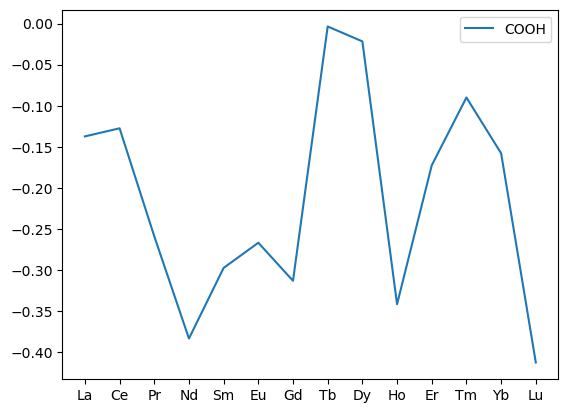

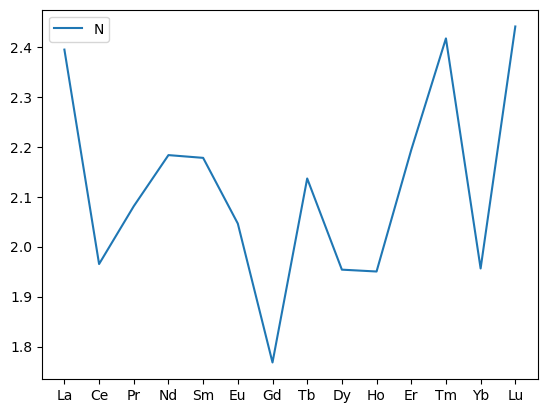

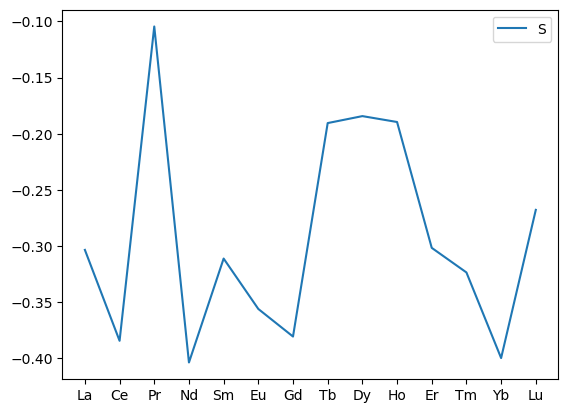

In [17]:
pt = Chem.GetPeriodicTable()
for pattern_name in result:
    plt.figure()
    plots = []
    for s in result[pattern_name]:
        if len(result[pattern_name][s]) > 0:
            plots += [[result[pattern_name][s][metal] for metal in Ln]]
    mean_scores = np.array(plots).mean(axis=0)
    vdw_radii = [pt.GetRvdw(el) for el in Ln]
    valent_radii = [pt.GetRcovalent(el) for el in Ln]
    x = range(len(Ln))
    plt.plot(x, mean_scores, label=pattern_name)
    plt.xticks(x, Ln)
    plt.legend()

## Comparison

In [9]:
test_metal = "Er"
device = torch.device("cuda")

path_to_sdf = str(ROOT_DIR / "Data/OneM_cond_adds/" / f"{test_metal}.sdf")
dataset = featurize_sdf_with_metal_and_conditions(path_to_sdf=path_to_sdf,
                                                  mol_featurizer=ConvMolFeaturizer(),
                                                  metal_featurizer=SkipatomFeaturizer(),
                                                  shuffle=False)
molecules = [(mol, p) for mol in Chem.SDMolSupplier(path_to_sdf) if mol is not None
             for p in mol.GetPropNames() if p.startswith("logK")]
smiles = [Chem.MolToSmiles(mol) for mol, p in molecules]

In [10]:
ids = [10, 14, 16, 27, 37, 47, 55, 56, 61, 74, 75, 77, 104, 113, 118, 160, 162, 173, 181, 233, 242, 260, 264, 270, 286]

dataset = [dataset[i] for i in ids]
molecules = [molecules[i] for i in ids]

Button(button_style='warning', description='<<< (0)', style=ButtonStyle())

Button(button_style='warning', description='(0) >>>', style=ButtonStyle())

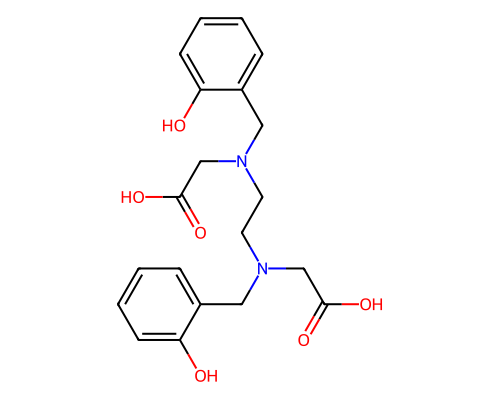

<DisplayHandle display_id=2>

In [11]:
from rdkit.Chem import Draw
from IPython.display import display, update_display
from ipywidgets import Button 

i = 0
next_button = Button(description=f"({i}) >>>", button_style='warning') # 'success', 'info', 'warning', 'danger', ''
prev_button = Button(description=f"<<< ({i})", button_style='warning') # 'success', 'info', 'warning', 'danger', ''

def update():
    global i, next_button, prev_button
    next_button.description = f"({i}) >>>"
    prev_button.description = f"<<< ({i})"
    new_img = Draw.MolToImage(molecules[i][0], size=(500, 400))
    update_display(new_img, display_id=2)
    
def prev_image(b):
    global i
    i -= 1
    update()

def next_image(b):
    global i
    i += 1
    update()

prev_button.on_click(prev_image)
next_button.on_click(next_image)
display(prev_button)
display(next_button)

display(Draw.MolToImage(molecules[i][0], size=(500, 400)), display_id=2)

### 1. Node Shapley

In [12]:
device = torch.device("cuda")

output_folder = str(ROOT_DIR / f"Output/comparison/")

create_path(os.path.join(output_folder, "node_shapley"))
create_path(os.path.join(output_folder, "node_subgraphX"))
create_path(os.path.join(output_folder, "сounterfactual_heatmap"))
create_path(os.path.join(output_folder, "сounterfactual_desc"))

folder = [f for f in os.listdir(ROOT_DIR / "Output/WithCondAdd/5fold") if f.startswith(test_metal)][0]
train_folder = str(ROOT_DIR / "Output/WithCondAdd/5fold" / folder)

model = ModelShell(GCNN_FCNN, train_folder, device=device)
value_func = lambda batch: model(batch.to(device))["logK"].detach().cpu()

In [80]:
for graph_id, (graph, (molecule, prop_name)) in tqdm(enumerate(zip(dataset, molecules)), total=len(dataset), desc="Molecules", leave=False):
    coalitions = all_connected_coalitions(graph, min_nodes=1, max_nodes=1)
    scores = {tuple(coalition): l_shapley(coalition=coalition, data=graph,
                                          local_radius=len(model.models[0].graph_sequential.conv_sequential),
                                          value_func=value_func,
                                          subgraph_building_method='zero_filling')
              for coalition in tqdm(coalitions, desc="Scoring", leave=False)}
    # scores = np.array([item[1] for item in sorted(scores.items(), key=lambda item: item[0][0])])

    pred = model(graph.to(model.models[0].device))["logK"].item()
    true = graph.y["logK"].item()
    filename = f"smiles={Chem.MolToSmiles(molecule)}&prop_name={prop_name}&pred={pred}&true={true}.png"
    visualize(molecule, scores, save_path=os.path.join(output_folder, "node_shapley", filename), normalize=True)

Molecules:   0%|          | 0/25 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/28 [00:00<?, ?it/s]

Scoring:   0%|          | 0/16 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/23 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/9 [00:00<?, ?it/s]

Scoring:   0%|          | 0/17 [00:00<?, ?it/s]

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Scoring:   0%|          | 0/13 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/15 [00:00<?, ?it/s]

Scoring:   0%|          | 0/10 [00:00<?, ?it/s]

Scoring:   0%|          | 0/11 [00:00<?, ?it/s]

Scoring:   0%|          | 0/3 [00:00<?, ?it/s]

/home/pikulin/stability_constant/Source/explanations/rdkit_heatmaps/molmapping.py:100: RuntimeWarning: divide by zero encountered in scalar divide
  height_to_width_ratio_mol = mol_height / mol_width


Scoring:   0%|          | 0/31 [00:00<?, ?it/s]

Scoring:   0%|          | 0/26 [00:00<?, ?it/s]

Scoring:   0%|          | 0/34 [00:00<?, ?it/s]

Scoring:   0%|          | 0/24 [00:00<?, ?it/s]

Scoring:   0%|          | 0/18 [00:00<?, ?it/s]

Scoring:   0%|          | 0/15 [00:00<?, ?it/s]

### 2. Node SubgraphX

In [8]:
from Source.explanations.subgraphx import SubgraphX

In [42]:
# for graph_id, (graph, (molecule, prop_name)) in tqdm(enumerate(zip(dataset, molecules)), total=len(dataset), desc="Molecules", leave=False):
#     explainer = SubgraphX(model, device=device,
#                           value_func=value_func, reward_method='l_shapley',
#                           min_atoms=max(1, molecule.GetNumAtoms()//4),
#                           verbose=True,)
#     result = explainer.explain(graph)
#     scores = {tuple(res["coalition"]): res["P"] for res in result}
    
#     pred = model(graph.to(model.models[0].device))["logK"].item()
#     true = graph.y["logK"].item()
#     filename = f"smiles={Chem.MolToSmiles(molecule)}&prop_name={prop_name}&pred={pred}&true={true}.png"
#     visualize(molecule, scores, save_path=os.path.join(output_folder, "node_subgraphX", filename), normalize=True)

Too slow for Jupyter :(

Run this code in `Source/explanations/node_subgraphX.py`.

### 3. Counterfactual

In [13]:
import exmol
import selfies as sf
import skunk
from cairosvg import svg2png

In [14]:
class ModelExmol(torch.nn.Module):
    def __init__(self, base_model, metal, charge, temperature, ionic_str):
        super().__init__()
        self.device = base_model.device
        self.model = base_model
        self.metal = metal
        
        conditions = torch.tensor([[charge, temperature, ionic_str]])
        metal_features = SkipatomFeaturizer().featurize(metal)
        self.metal_x = torch.cat((metal_features, conditions), dim=-1).to(self.device)
        
    def forward(self, smiles, selfies):
        mol = Chem.MolFromSmiles(sf.decoder(selfies))
        graph = ConvMolFeaturizer().featurize(mol).to(self.device)
        graph.metal_x = self.metal_x
        
        return self.model(graph)["logK"].detach().item()

In [17]:
for graph_id, (graph, (molecule, prop_name)) in tqdm(enumerate(zip(dataset, molecules)), total=len(dataset), desc="Molecules", leave=False):
    _, metal, z, T, I = prop_name.split("_")
    z = float(z.split("=")[1])
    T = float(T.split("=")[1])
    I = float(I.split("=")[1])
    
    model_exmol = ModelExmol(model, metal=metal, charge=z, temperature=T, ionic_str=I)
    
    pred = model(graph.to(model.device))["logK"].item()
    true = graph.y["logK"].item()
    filename = f"smiles={Chem.MolToSmiles(molecule)}&prop_name={prop_name}&pred={pred}&true={true}.png"
    save_path_hm = os.path.join(output_folder, "сounterfactual_heatmap", filename)
    save_path_desc = os.path.join(output_folder, "сounterfactual_desc", filename)
    if os.path.exists(save_path_hm) and os.path.exists(save_path_desc): continue

    samples = exmol.sample_space(Chem.MolToSmiles(molecule), model_exmol, batched=False, use_selfies=True)
    exmol.lime_explain(samples, descriptor_type='ECFP')

    if not os.path.exists(save_path_hm):
        svg2png(bytestring=exmol.plot_utils.similarity_map_using_tstats(samples[0], return_svg=True),
                write_to=save_path_hm)

    if not os.path.exists(save_path_desc):
        svg2png(bytestring=exmol.plot_descriptors(samples, return_svg=True),
                write_to=save_path_desc)

Molecules:   0%|          | 0/25 [00:00<?, ?it/s]



  0%|                                                                                                                                                                                                               | 0/3000 [00:00<?, ?it/s]

🥌STONED🥌 Mutations: 1:   0%|                                                                                                                                                                                      | 0/3000 [00:00<?, ?it/s]

🥌STONED🥌 Mutations: 1:  50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1500/3000 [00:00<00:00, 1596.03it/s]

🥌STONED🥌 Mutations: 2:  50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1500/3000 [00:00<00:00, 1596.03it/s]

🥌STONED🥌 Mutations: 2: 100%|████████████████████

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/2006 [00:00<?, ?it/s]
🔭Projecting...🔭:  36%|██████████████████████████████████████████████████████████████▊                                                                                                               | 724.5/2006 [00:00<00:00, 7243.07it/s]
🔭Projecting...🔭:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1774.0/2006 [00:00<00:00, 9153.40it/s]
🥰Finishing up🥰: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2006.0/2006 [00:04<00:00, 9153.40it/s]
🤘Done🤘: 100%|███████████████████████████████████████████

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/1482 [00:00<?, ?it/s]
🥰Finishing up🥰: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1482.0/1482 [00:01<00:00, 997.48it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1482.0/1482 [00:01<00:00, 971.73it/s]

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/2183 [00:00<?, ?it/s]
🔭Projecting...🔭:  38%|█████████████████████████████████

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/1702 [00:00<?, ?it/s]
🥰Finishing up🥰: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1702.0/1702 [00:01<00:00, 941.92it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1702.0/1702 [00:01<00:00, 920.33it/s]

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/1971 [00:00<?, ?it/s]
🔭Projecting...🔭:  72%|█████████████████████████████████

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/2249 [00:00<?, ?it/s]
🔭Projecting...🔭:  44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 986.5/2249 [00:00<00:00, 9860.87it/s]
🥰Finishing up🥰: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2249.0/2249 [00:03<00:00, 9860.87it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2249.0/2249 [00:03<00:00, 574.48it/s]

🔭Projecting...🔭:   0%|                                 

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/2377 [00:00<?, ?it/s]
🔭Projecting...🔭:  42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                    | 999.0/2377 [00:00<00:00, 9984.77it/s]
🥰Finishing up🥰: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2377.0/2377 [00:04<00:00, 9984.77it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2377.0/2377 [00:04<00:00, 503.05it/s]

🔭Projecting...🔭:   0%|                                 

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/2132 [00:00<?, ?it/s]
🔭Projecting...🔭:  72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1534.5/2132 [00:00<00:00, 15342.78it/s]
🥰Finishing up🥰: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2132.0/2132 [00:03<00:00, 15342.78it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2132.0/2132 [00:03<00:00, 685.74it/s]

🔭Projecting...🔭:   0%|                                 

🔭Projecting...🔭:  47%|██████████████████████████████████████████████████████████████████████████████████                                                                                           | 1283.5/2705 [00:00<00:00, 4318.99it/s]
🔭Projecting...🔭:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2202.0/2705 [00:00<00:00, 6238.90it/s]
🥰Finishing up🥰: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2705.0/2705 [00:11<00:00, 6238.90it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2705.0/2705 [00:11<00:00, 228.84it/s]

🔭Projecting...🔭:   0%|                                 

🔭Projecting...🔭:  23%|███████████████████████████████████████▌                                                                                                                                      | 597.5/2632 [00:00<00:00, 2994.77it/s]
🔭Projecting...🔭:  35%|█████████████████████████████████████████████████████████████▌                                                                                                                | 931.5/2632 [00:00<00:00, 3150.23it/s]
🔭Projecting...🔭:  48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1276.0/2632 [00:00<00:00, 3265.63it/s]
🔭Projecting...🔭:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1983.5/2632 [00:00<00:00, 4637.87it/s]
🥰Finishing up🥰: 100%|███████████████████████████████████

🔭Projecting...🔭:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1533.5/2446 [00:00<00:00, 7880.28it/s]
🥰Finishing up🥰: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2446.0/2446 [00:06<00:00, 7880.28it/s]
🤘Done🤘: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2446.0/2446 [00:06<00:00, 387.74it/s]

🔭Projecting...🔭:   0%|                                                                                                                                                                                            | 0/2287 [00:00<?, ?it/s]
🔭Projecting...🔭:  35%|█████████████████████████████████

### Comparison

In [32]:
from PIL import Image

In [52]:
def join_imgs(imgs):
    max_shape = sorted([(np.sum(i.size), i.size ) for i in imgs], reverse=True)[0][1]
    imgs_comb = np.hstack([i.resize(max_shape) for i in imgs])
    return Image.fromarray(imgs_comb)

def save_to_pdf(imgs, filename):
    imgs[0].save(filename, save_all=True, append_images=imgs[1:])

In [28]:
output_folder = str(ROOT_DIR / f"Output/comparison/")

node_shapley_path = os.path.join(output_folder, "node_shapley")
node_subgraphX_path = os.path.join(output_folder, "node_subgraphX")
сounterfactual_heatmap_path = os.path.join(output_folder, "сounterfactual_heatmap")
сounterfactual_desc_path = os.path.join(output_folder, "сounterfactual_desc")

In [69]:
filenames = list(set(os.listdir(node_shapley_path) + os.listdir(node_subgraphX_path) + os.listdir(сounterfactual_heatmap_path) + os.listdir(сounterfactual_desc_path)))

heatmap_explanations = []
desc_explanations = []

for filename in filenames:
    node_shapley_img = Image.open(os.path.join(node_shapley_path, filename)) if os.path.exists(os.path.join(node_shapley_path, filename)) else None
    node_subgraphX_img = Image.open(os.path.join(node_subgraphX_path, filename)) if os.path.exists(os.path.join(node_subgraphX_path, filename)) else Image.fromarray(np.array(node_shapley_img) * 0 + 255)
    сounterfactual_heatmap_img = Image.open(os.path.join(сounterfactual_heatmap_path, filename)) if os.path.exists(os.path.join(сounterfactual_heatmap_path, filename)) else None
    сounterfactual_desc_img = Image.open(os.path.join(сounterfactual_desc_path, filename)) if os.path.exists(os.path.join(сounterfactual_desc_path, filename)) else None
    if None not in [node_shapley_img, node_subgraphX_img, сounterfactual_heatmap_img, сounterfactual_desc_img]:
        heatmap_explanations += [join_imgs([
            node_shapley_img,
            node_subgraphX_img,
            сounterfactual_heatmap_img,
        ])]
        desc_explanations += [join_imgs([
            node_shapley_img,
            node_subgraphX_img,
            сounterfactual_desc_img,
        ])]

In [70]:
save_to_pdf(heatmap_explanations, os.path.join(output_folder, "heatmap_explanations.pdf"))
save_to_pdf(desc_explanations, os.path.join(output_folder, "desc_explanations.pdf"))